In [1]:
import datetime as dt
import sys
sys.path.insert(0,'../..')
from typing import List
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import numpy as np
from scipy.special import comb
import pandas as pd
import seaborn
import pprint
import deepdiff
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from rivapy.tools.datetime_grid import DateTimeGrid
from rivapy.models.residual_demand_fwd_model import WindPowerForecastModel, MultiRegionWindForecastModel, LinearDemandForwardModel
from rivapy.instruments.ppa_specification import GreenPPASpecification
from rivapy.models.residual_demand_model import SmoothstepSupplyCurve
from rivapy.models import OrnsteinUhlenbeck
from rivapy.pricing.green_ppa_pricing import GreenPPADeepHedgingPricer, DeepHedgeModel


import analysis

from IPython.display import display, HTML
#display(HTML("<style>.container { width:80% !important; }</style>"))

%load_ext autoreload
%autoreload 2
%matplotlib inline




c:\Users\Anwender\Documents\GitHub\RiVaPy_development\RiVaPy\sandbox\green_ppa\../..\rivapy\__init__.py:11: UserWarning: The pyvacon module is not available. You may not use all functionality without this module. Consider installing pyvacon.
  warnings.warn('The pyvacon module is not available. You may not use all functionality without this module. Consider installing pyvacon.')


In [2]:
def setup(ref_key, ref_key_volume_hedge):
    sim_results = {}
    forecast_points={}
    # simulate paths
    print('simulate paths')
    for k in ref_keys:
        sim_results[k], forecast_points[k] = repo.simulate_model(k, n_sims=100_000)
    # load models and specs
    print('load models and specs')
    hedge_models = {k: repo.get_hedge_model(k) for k in ref_keys}
    specs = {k: GreenPPASpecification.from_dict(repo.results[k]['ppa_spec']) for k in ref_keys}
    #compute pathwise pnls
    print('compute pnl')
    paths = {k:{l:sim_results[k].get(l, forecast_points[k]) for l in ['Power_Germany_FWD0', 'Onshore_FWD0', 'Offshore_FWD0']} for k in ref_keys}
    pnl = {
        'volume_hedge': compute_volume_hedge_pnl(paths[ref_key_volume_hedge], specs[ref_key_volume_hedge]),
          'no_hedge': compute_no_hedge_pnl(paths[ref_key_volume_hedge], specs[ref_key_volume_hedge]),
        'static_volume_hedge':compute_static_volume_hedge_pnl(paths[ref_key_volume_hedge], specs[ref_key_volume_hedge])
          }
    for k,v in hedge_models.items():
        pnl[k] = compute_pnl(v, paths[k], specs[k])#specs['ec202973a34dfc5b71a86e0e7b2209a62c29b6a1'])#
    return sim_results, forecast_points, hedge_models, specs, paths, pnl

def compute_pnl(hedge_model, paths, green_ppa_spec):
    power_price = paths.get('Power_Germany_FWD0', None)
    volume = paths.get(green_ppa_spec.location+'_FWD0')
    print(green_ppa_spec.fixed_price)
    payoff = (power_price[-1,:] -green_ppa_spec.fixed_price)*(volume[-1,:])*green_ppa_spec.max_capacity
    return hedge_model.compute_pnl(paths, payoff)

def compute_volume_hedge_pnl(paths, green_ppa_spec):
    power_price = paths.get('Power_Germany_FWD0', None)
    volume = paths.get(green_ppa_spec.location+'_FWD0')
    pnl = volume[0,:]*power_price[0,:]
    for i in range(1,power_price.shape[0]-1):
        pnl += (volume[i,:]-volume[i-1,:])*power_price[i,:]
    pnl -= volume[-2,:]*power_price[-1,:]
    pnl += (power_price[-1,:] -green_ppa_spec.fixed_price)*(volume[-1,:])*green_ppa_spec.max_capacity
    return pnl

def compute_no_hedge_pnl(paths, green_ppa_spec):
    power_price = paths.get('Power_Germany_FWD0', None)
    volume = paths.get(green_ppa_spec.location+'_FWD0')
    pnl = (power_price[-1,:] -green_ppa_spec.fixed_price)*(volume[-1,:])*green_ppa_spec.max_capacity
    return pnl


def compute_static_volume_hedge_pnl(paths, green_ppa_spec):
    power_price = paths.get('Power_Germany_FWD0', None)
    volume = paths.get(green_ppa_spec.location+'_FWD0')
    pnl = (power_price[-1,:] -green_ppa_spec.fixed_price)*(volume[-1,:]) + (-power_price[-1,:] +power_price[0,:])*(volume[0,:])
    return pnl

def compute_static_volume_hedge_var_pnl(paths, hedge_volume, green_ppa_spec, strike=None):
    power_price = paths.get('Power_Germany_FWD0', None)
    volume = paths.get(green_ppa_spec.location+'_FWD0')
    strike_ = green_ppa_spec.fixed_price
    if strike is not None:
        strike_ = strike
    pnl = (power_price[-1,:] -strike_)*(volume[-1,:]) + (-power_price[-1,:] +power_price[0,:])*(hedge_volume)
    tmp = np.percentile(pnl, 5)
    return pnl[pnl<tmp].mean()#pnl.var()


def compute_statistics(pnl, labels):
    pnl_stat = {'name':[], 'mean': [], 'var':[],'p-skewness':[], 
                #'20%': [], 
                #'5%':[], 
                #'10%':[], 
                '5% ES':[], 
                #'10% ES':[], 
                '20% ES':[], 
               'utility, 0.05': [], 
                'utility, 0.1': [],
                #'utility, 0.15': [], 'utility, 0.2': [], 
               }
    for k,v in pnl.items():
        if ( k == 'static_volume_hedge'):# or (k==): # (k == 'no_hedge') or
            continue
        v_ = 100.0*v
        if k in labels.keys():
            pnl_stat['name'].append(labels[k])
        else:
            pnl_stat['name'].append(k)
        pnl_stat['mean'].append(np.mean(v_))
        pnl_stat['var'].append(np.sqrt(np.var(v_)))
        pnl_stat['p-skewness'].append( 3.0*(v_.mean()-np.median(v_))/v_.std())

        tmp = np.percentile(v_, 10)
        #pnl_stat['10%'].append(tmp)
        tmp = v_[v_<tmp].mean()
        #pnl_stat['10% ES'].append(tmp) 

        tmp = np.percentile(v_, 20)
        #pnl_stat['20%'].append(tmp)
        tmp = v_[v_<tmp].mean()
        pnl_stat['20% ES'].append(tmp)
        tmp = np.percentile(v_, 5)
        #pnl_stat['5%'].append(tmp)
        tmp = v_[v_<tmp].mean()
        pnl_stat['5% ES'].append(tmp)
        
        pnl_stat['utility, 0.05'].append(np.mean(np.exp(-0.05*v_)))
        pnl_stat['utility, 0.1'].append(np.mean(np.exp(-0.1*v_)))
        #pnl_stat['utility, 0.15'].append(np.mean(np.exp(-0.15*v_)))
        #pnl_stat['utility, 0.2'].append( np.mean(np.exp(-0.2*v_)))

    pnl_stat = pd.DataFrame(pnl_stat)
    return pnl_stat.set_index('name')#.to_latex(float_format="{:0.3f}".format)

In [3]:
wind_onshore = WindPowerForecastModel(region='Onshore', speed_of_mean_reversion=2.0, volatility=4.0)
wind_offshore = WindPowerForecastModel(region='Offshore', speed_of_mean_reversion=2.0, volatility=3.0)
regions = [ MultiRegionWindForecastModel.Region( 
                                    wind_onshore,
                                    capacity=1000.0,
                                    rnd_weights=[0.8,0.2]
                                ),
           MultiRegionWindForecastModel.Region( 
                                    wind_offshore,
                                    capacity=100.0,
                                    rnd_weights=[0.2,0.8]
                                )
           
          ]
wind = MultiRegionWindForecastModel('Wind_Germany', regions)

model = LinearDemandForwardModel(wind_power_forecast=wind, 
                                 x_volatility = 4.0 , 
                                 x_mean_reversion_speed = 0.1,
                                 power_name= 'Power_Germany')

In [14]:
val_date = dt.datetime(2023,1,1)
strike = 1.0 #0.22
spec = GreenPPASpecification(udl='Power_Germany',
                            technology = 'Wind',
                             location = 'Onshore',
                             schedule = [val_date + dt.timedelta(days=2)], 
                             fixed_price=strike,
                             max_capacity = 1.0)

In [15]:
repo = analysis.Repo('./experiments/')

In [24]:
pricing_results = repo.run(val_date, 
                           spec, model, 
                           initial_forecasts={'Onshore': [0.8],
                                        'Offshore': [0.6]},
                           power_fwd_prices=[1.0],
                           forecast_hours=[10, 14, 18],
                           additional_states=['Offshore'],
                           depth=3, 
                           nb_neurons=64, 
                           n_sims=100_000, 
                           regularization=0.0,
                           epochs=1, verbose=1,
                           tensorboard_logdir = 'logs/' + dt.datetime.now().strftime("%Y%m%dT%H%M%S"), 
                           initial_lr=5e-4,
                           decay_steps=8_000,
                           batch_size=100, decay_rate=0.8, seed=42,
                           transaction_cost = {'Power_Germany_FWD0': [0.001]})



[datetime.datetime(2023, 1, 3, 0, 0)]


OperatorNotAllowedInGraphError: in user code:

    File "c:\Users\Anwender\.conda\envs\rivapyFS\Lib\site-packages\keras\engine\training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\Anwender\.conda\envs\rivapyFS\Lib\site-packages\keras\engine\training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Anwender\.conda\envs\rivapyFS\Lib\site-packages\keras\engine\training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\Anwender\.conda\envs\rivapyFS\Lib\site-packages\keras\engine\training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\Anwender\Documents\GitHub\RiVaPy_development\RiVaPy\sandbox\green_ppa\../..\rivapy\pricing\deep_hedging.py", line 61, in __call__
        return self._compute_pnl_withtransactioncost(x, training) #+ self.price
    File "c:\Users\Anwender\Documents\GitHub\RiVaPy_development\RiVaPy\sandbox\green_ppa\../..\rivapy\pricing\deep_hedging.py", line 101, in _compute_pnl_withtransactioncost
        for i in tf.range(self.timegrid.shape[0]-2):# TODO_FS: Tensorflow loop?

    OperatorNotAllowedInGraphError: Iterating over a symbolic `tf.Tensor` is not allowed: AutoGraph did convert this function. This might indicate you are trying to use an unsupported feature.


In [42]:
repo.results.keys()

dict_keys(['a641a2313124d83a67bbcbce9ef00cf83b26f13d', 'c047fbd62cbbb69dfb783b73c54cd49bea910e1f', 'acbb05123fdd2384bbaabc11b31311da0583ee31', '17ab9f49cde592b9058c2e75e20e53bfe00b8bd9', 'e14608efd681231308bfe57ac08418e3bf0d752f'])

In [46]:
experiments = {}
    
tmp={
        'ref_keys':[
            '17ab9f49cde592b9058c2e75e20e53bfe00b8bd9',
            'e14608efd681231308bfe57ac08418e3bf0d752f'
        ],
        'labels':{
            '17ab9f49cde592b9058c2e75e20e53bfe00b8bd9':'no_tc with dict',
            'e14608efd681231308bfe57ac08418e3bf0d752f':'tc = 0.0001'
            
        }
}
experiments['transaction_cost_test1'] = tmp

# PnL Distribution for Experiments

In [47]:
repo = analysis.Repo('./experiments/')
# TODO: das muss wieder weg und in die serialisierung
for k,v in repo.results.items():
    v['val_date'] = dt.datetime.fromisoformat(v['val_date'])
    v['ppa_spec']['schedule'] = [dt.datetime.fromisoformat(k) for k in v['ppa_spec']['schedule']]

In [48]:
experiment = 'transaction_cost_test1'
ref_keys = experiments[experiment]['ref_keys']
labels = experiments[experiment]['labels']
labels_T = {k:v for v,k in labels.items()}
sim_results, forecast_points, hedge_models, specs, paths, pnl = setup(ref_keys, ref_key_volume_hedge=labels_T['no_tc with dict'])

simulate paths
load models and specs


compute pnl
1.0
3125/3125 [==============================] - 27s 7ms/step
1.0
0.001
0.001
0.001
0.001
0.001
0.001
0.001
0.001
0.001
0.001
0.001
0.001
0.001
0.001
0.001
0.001
0.001
0.001
0.001
0.001
0.001
0.001
0.001
0.001
0.001
0.001
0.001
0.001
0.001
0.001
0.001
0.001
0.001
0.001
0.001
0.001
0.001
0.001
0.001
0.001
0.001
0.001
0.001
0.001
0.001
0.001
0.001
bla
3125/3125 [==============================] - 18s 4ms/step


In [49]:
pnl.keys()

dict_keys(['volume_hedge', 'no_hedge', 'static_volume_hedge', '17ab9f49cde592b9058c2e75e20e53bfe00b8bd9', 'e14608efd681231308bfe57ac08418e3bf0d752f'])

Text(0.5, 0, 'PnL')

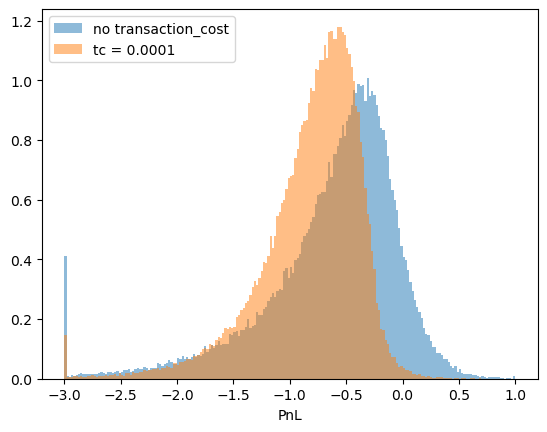

In [72]:
key = '17ab9f49cde592b9058c2e75e20e53bfe00b8bd9'
plt.hist(np.clip(100*pnl[key], -3,1), bins=200, label='no transaction_cost', density=True, alpha=0.5)
key = 'e14608efd681231308bfe57ac08418e3bf0d752f'
plt.hist(np.clip(100*pnl[key], -3,1), bins=200, label='tc = 0.0001', density=True, alpha=0.5)
plt.legend()
plt.xlabel('PnL')

(-6.2602405249248205, 2.62860468515167)

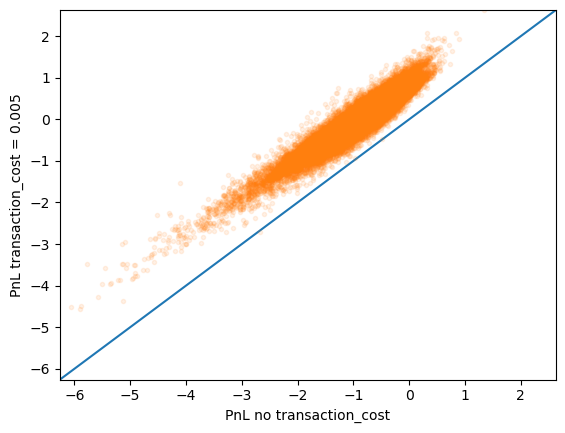

In [135]:
key = '88b5d0ffbdaf5ce2e221de3ea993b3ff4707fbdb'
pnl1 = 100*pnl[key]
key = 'af85defde5263cb515b50590d2d6605cc5346b59'
pnl2 = 100*pnl[key]
pnl_min = np.min(100*pnl[key])
pnl_max = np.max(100*pnl[key])

plt.plot([pnl_min,pnl_max], [pnl_min,pnl_max], '-')
plt.plot(pnl1,pnl2,'.', alpha=0.1)
plt.xlabel('PnL no transaction_cost')
plt.ylabel('PnL transaction_cost = 0.005')
plt.xlim(pnl_min, pnl_max)
plt.ylim(pnl_min, pnl_max)

In [131]:
df = compute_statistics(pnl, labels)
#df=df.reset_index()
pd.options.display.float_format = '{:,.4f}'.format
df

,mean,var,p-skewness,5% ES,20% ES,"utility, 0.05","utility, 0.1"
name,,,,,,,
volume_hedge,-0.6388,0.6474,-0.8691,-2.6562,-1.6159,1.0330,1.0684
no_hedge,-1.0423,14.2003,0.1095,-28.6662,-20.4023,1.3401,2.7755
transaction_cost = 0.001,-0.4530,0.5619,-0.6678,-2.1200,-1.3103,1.0233,1.0481
transaction_cost = 0.005,0.2482,0.4547,-0.5865,-1.0393,-0.4428,0.9879,0.9765
no transaction_cost,-0.6389,0.4813,-0.6428,-2.0434,-1.3704,1.0328,1.0673
